<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_05/02_Intermediate_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip uninstall -y keras keras-nightly keras-hub-nightly efficientnet segmentation-models
!pip install --quiet tensorflow keras

import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Found existing installation: keras 3.9.0
Uninstalling keras-3.9.0:
  Successfully uninstalled keras-3.9.0


In [5]:
# Define a U-Net model from scratch
def unet_model(input_shape=(128, 128, 3), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(num_classes, (1, 1), activation=None)(c5)  # No activation

    model = Model(inputs, outputs)
    return model

In [7]:
# Create U-Net model
model = unet_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Summary of the model
model.summary()

# Load Oxford-IIIT Pet Dataset (with segmentation masks)
dataset_name = "oxford_iiit_pet"
(train_ds, test_ds), ds_info = tfds.load(
    dataset_name, split=["train[:80%]", "train[80%:]"],
    with_info=True, as_supervised=False
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 128, 128, 3)         │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,698,947 (6.48 MB)

 Trainable params: 1,698,947 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Extract images and segmentation masks
def load_image_and_mask(data):
    image = tf.image.resize(data["image"], (128, 128)) / 255.0  # Normalize image

    mask = tf.image.resize(data["segmentation_mask"], (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.int32)  # Ensure integer class labels
    mask = tf.clip_by_value(mask, 0, 2)  # Ensure class labels are valid (0, 1, 2)

    return image, mask

In [9]:

# Preprocess dataset
train_ds = train_ds.map(load_image_and_mask).batch(16).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image_and_mask).batch(16).prefetch(tf.data.AUTOTUNE)

# Train the model
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.6754 - loss: 0.7316 - val_accuracy: 0.7104 - val_loss: 0.5601
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - accuracy: 0.7277 - loss: 0.5015 - val_accuracy: 0.7382 - val_loss: 0.5092
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.7524 - loss: 0.4727 - val_accuracy: 0.7422 - val_loss: 0.4964
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.7615 - loss: 0.4674 - val_accuracy: 0.7681 - val_loss: 0.4647
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.7855 - loss: 0.4360 - val_accuracy: 0.8073 - val_loss: 0.4099


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


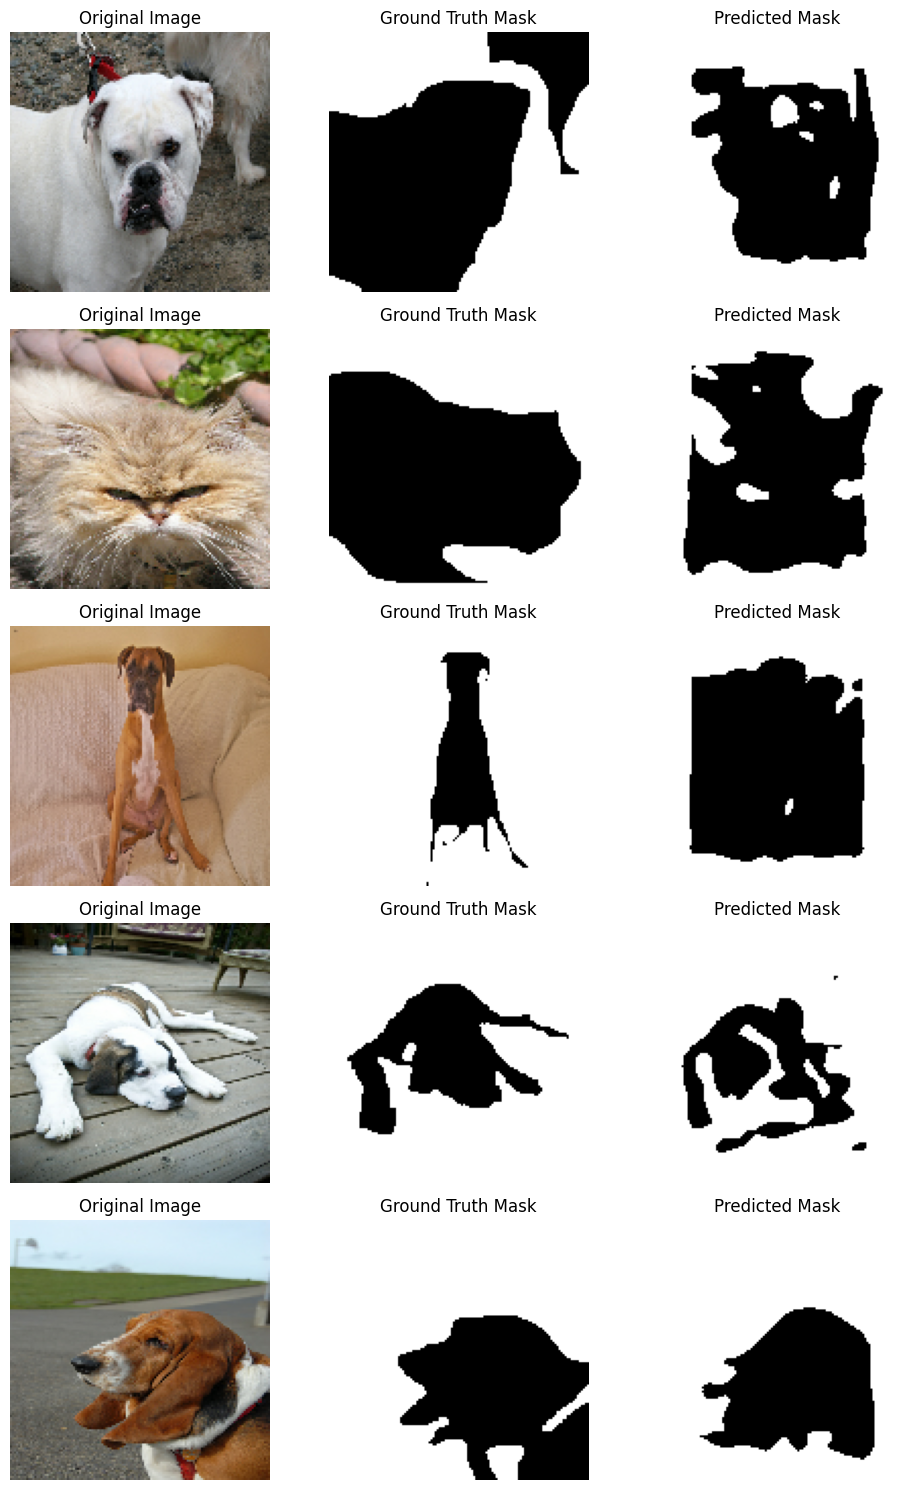

In [10]:
import matplotlib.pyplot as plt

# Function to visualize predictions
def display_predictions(model, dataset, num_images=5):
    sample_images, sample_masks = next(iter(dataset.take(1)))  # Get a batch from test set

    # Predict the segmentation mask
    predicted_masks = model.predict(sample_images)

    # Convert softmax probabilities to class labels (argmax)
    predicted_masks = tf.argmax(predicted_masks, axis=-1)

    # Convert ground truth masks to 2D format
    sample_masks = tf.squeeze(sample_masks, axis=-1)

    # Plot images, ground truth, and predictions
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    for i in range(num_images):
        axes[i, 0].imshow(sample_images[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(sample_masks[i], cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(predicted_masks[i], cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to display results
display_predictions(model, test_ds, num_images=5)
